In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11664931.33it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203681.02it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3750933.83it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6300635.25it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



We downloaded the dataset above. Now let's start by building a new model and adding some dropout

In [ ]:
from torch import nn,optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # let's create the layers for our model
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

    # Dropout module with 20% drop prob
    # i.e., drops 20% units from each layer during each step
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):

    # let's perform internal flattening of tensor
    x = x.view(x.shape[0], -1)

    # now we add dropouts for all middle layers
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))

    # for final layer no dropout should be present
    x = F.log_softmax(self.fc4(x), dim=1)

    return x


In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.600..  Test Loss: 0.455..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.480..  Test Loss: 0.437..  Test Accuracy: 0.841
Epoch: 3/30..  Training Loss: 0.449..  Test Loss: 0.424..  Test Accuracy: 0.844
Epoch: 4/30..  Training Loss: 0.429..  Test Loss: 0.422..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.421..  Test Accuracy: 0.845
Epoch: 6/30..  Training Loss: 0.413..  Test Loss: 0.404..  Test Accuracy: 0.853
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.406..  Test Accuracy: 0.854
Epoch: 8/30..  Training Loss: 0.398..  Test Loss: 0.406..  Test Accuracy: 0.852
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.426..  Test Accuracy: 0.851
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.394..  Test Accuracy: 0.864
Epoch: 11/30..  Training Loss: 0.386..  Test Loss: 0.379..  Test Accuracy: 0.870
Epoch: 12/30..  Training Loss: 0.384..  Test Loss: 0.394..  Test Accuracy: 0.863
Epoch: 13/30..  Training Loss: 0.377.

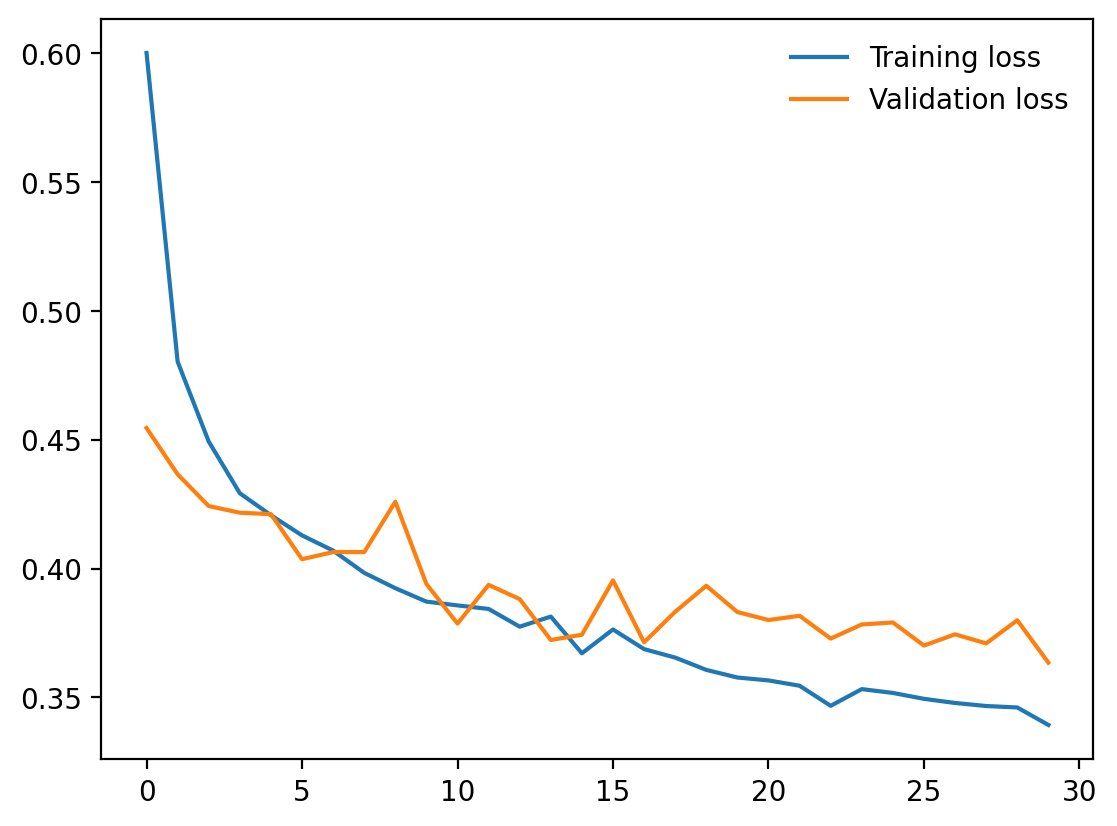

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

ok let's test our network i.e., ***Inference***

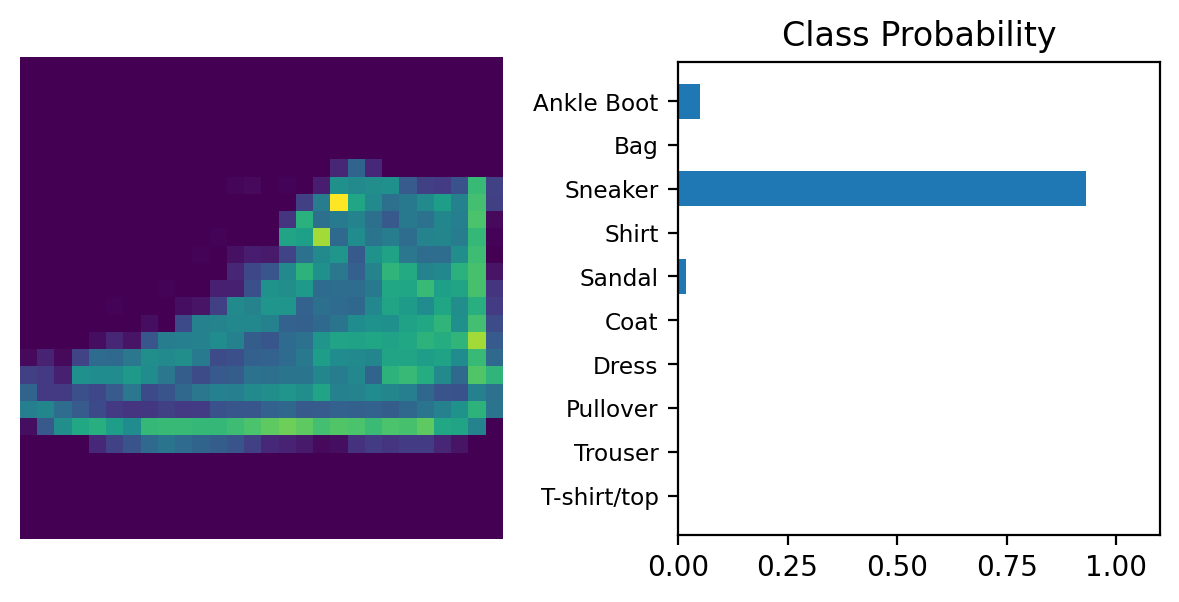

In [ ]:
# Test out your network!

model.eval()

images, labels = next(iter(testloader))
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
new_state_dict = torch.load('checkpoint.pth')
print(new_state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


But we need to rebuild the model exactly as it was when trained in order for a new model to be built.